# Digital Filtering - EEG Solution

EEG acquired signals are highly vulnerable to different kind of noise. 
Some noise can be avoided by preparation of test surroundings, hence other noise can not be avoided and must be removed by specific filtering methods.
The Signal-to-Noise ratio (SNR)  of an acquired EEG signal is a measure of signal quality and describes the ratio of signal power to noise power. The raw Electroencephalogram (EEG) data needs filtering in order for proper noise reduction and signal evaluation.
Reasons and implications of artefacts causing the noise are discussed in this Jupyter Notebook as well as the application and implication of different filters on the signal.

EEG frequencies fall into different bands and are subdivided into:
- Delta (0.5-3Hz) These brainwaves are most commonly observed in people during deep sleep when no dreaming occurs. 
- Theta (3-7Hz) These brainwaves are particularly prevalent in the first stage of sleep and when people are daydreaming. 
- Alpha (8-13Hz) These brainwaves are present in the period of time right after the task is completed and you are relaxing.
- Beta (13-30Hz) These brainwaves are present when solving complex math problems or a puzzle. 
- Gamma (30-90Hz) These brainwaves reflect a conscious awareness of what is around us and relate to feelings of happiness and compassion. They are also prevalent while processing information and learning at a high level. 

## Data analysis

First step is to load the needed packages:

In [1]:
# Biosignalsnotebooks python package
import biosignalsnotebooks as bsnb

# Package used for loading data from the input h5 file
import h5py
from h5py import File

# Scientific packages
from numpy import array, mean
import numpy as np
from scipy.signal import welch
from scipy import signal
import matplotlib.pyplot as plt

We then import the recorded signal by entering the absolute path. 

In [2]:
file_path = "C://Users//smarocco.inst//Desktop//SUPSI//WORK//LAB BioSgn//EEG_Ste.h5"
h5_object = File(file_path)

The objects we are going to analyze are files of type .h5.

Let us proceed to analyze the composition of the file in a hierarchical manner:

In [3]:
# Keys list (.h5 hierarchy ground level)
list(h5_object.keys())

['84:BA:20:54:5E:DA']

In [4]:
h5_group = h5_object.get('84:BA:20:54:5E:DA')
print ("Second hierarchy level: " + str(list(h5_group)))

Second hierarchy level: ['digital', 'events', 'plugin', 'raw', 'support']


In [5]:
print ("Metadata of h5_group: \n" + str(list(h5_group.attrs.keys())))

Metadata of h5_group: 
['channels', 'comments', 'date', 'device', 'device connection', 'device name', 'digital IO', 'duration', 'firmware version', 'keywords', 'macaddress', 'mode', 'nsamples', 'resolution', 'sampling rate', 'sync interval', 'time']


In [6]:
sampling_rate = h5_group.attrs.get("sampling rate")
print ("Sampling Rate: " + str(sampling_rate))

Sampling Rate: 1000


For this experiment we are interested in manipulating data from sensors, so we are going to modify the "raw" data.  We therefore access the third hierarchical level of the data format. 

In [7]:
h5_sub_group = h5_group.get("raw")
print("Third hierarchy level: " + str(list(h5_sub_group)))

Third hierarchy level: ['channel_1', 'channel_2', 'channel_3', 'channel_4', 'channel_5', 'channel_6', 'nSeq']


From here the recorded data for each sensor channel can be accessed. In our case we will use the data recorded on channel 1 and on channel 2. 

To facilitate data manipulation operations we transform a nested list to a flatten list. We then generate the signal reference time using the function bsnb.generate_time(). 

In [8]:
h5_data_ch1 = h5_sub_group.get("channel_1")
h5_data_ch2 = h5_sub_group.get("channel_2")
# Conversion of a nested list to a flatten list by list-comprehension
# The following line is equivalent to:
# for sublist in h5_data:
#    for item in sublist:
#        flat_list.append(item)
data_list_ch1 = [item for sublist in h5_data_ch1 for item in sublist]
time_ch1 = bsnb.generate_time(data_list_ch1, sampling_rate)

data_list_ch2 = [item for sublist in h5_data_ch2 for item in sublist]
time_ch2 = bsnb.generate_time(data_list_ch2, sampling_rate)

Two relevant parameters are the sampling rate and the resolution of the ADC resolution. Both of theese parameters can be obtained by the .h5 file. 

In [9]:
resolution_ch1 = h5_group.attrs.get("resolution")[5]
resolution_ch2 = h5_group.attrs.get("resolution")[6]

print('Resolution of the first channel in bit: ', resolution_ch1)
print('Resolution of the second channel in bit: ', resolution_ch2)

Resolution of the first channel in bit:  10
Resolution of the second channel in bit:  10


It is now needed to convert the raw EEG signal to its physical units, to do this we have to use the transfer function of the EEG sensor:

$$ EEG(uV) = \frac{(\frac{ADC}{2^n}-0.5) \cdot VCC}{G_{EEG}}$$

Where
- VCC = 3V
- G = 40000
- ADC = Value sampled from the channel
- n = Number of bits of the channel

In [10]:
#Convert the signal using the formula, take in account that the voltage is expressed in uV.
signal_ch1 = (((data_list_ch1/(2**resolution_ch1))-0.5)*3000000)/40000
signal_ch2 = (((data_list_ch2/(2**resolution_ch2))-0.5)*3000000)/40000

To understand what we are analyzing let plot the graphs for channel 1 and channel 2. 

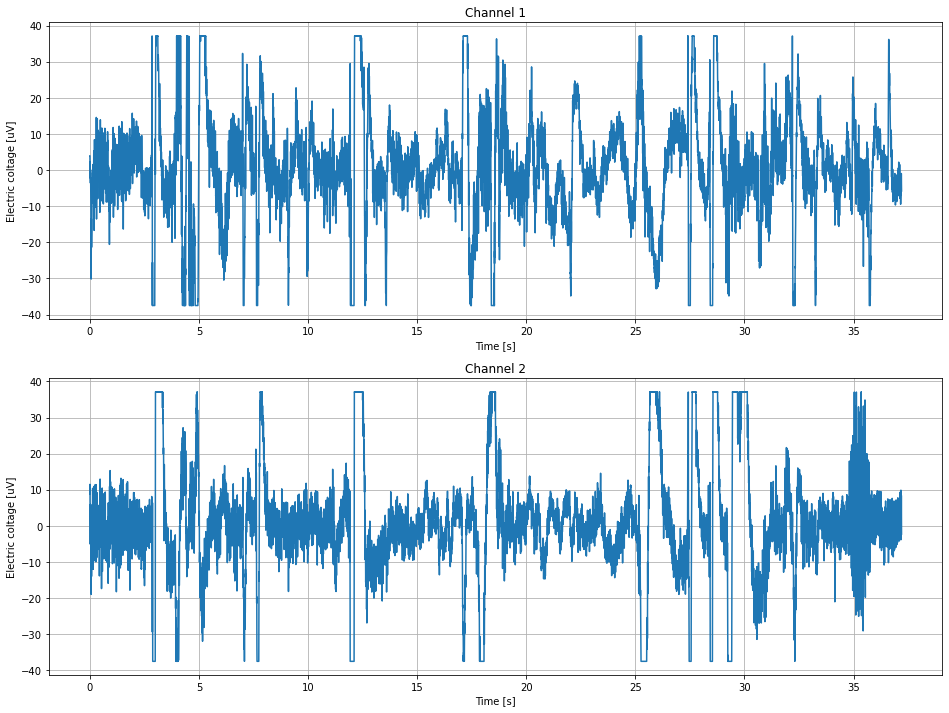

In [11]:
# Create three subplots to represent the signals
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,12))
ax1.plot(time_ch1, signal_ch1)
ax1.set_title('Channel 1')
ax1.set_ylabel('Electric coltage [uV]')
ax1.set_xlabel('Time [s]')
ax1.grid()
ax2.plot(time_ch2, signal_ch2)
ax2.set_title('Channel 2')
ax2.set_ylabel('Electric coltage [uV]')
ax2.set_xlabel('Time [s]')
ax2.grid()

Blinking of the eyes or movements of the skull generate artefacts in the signal that lead to sensor saturation. As can easily be seen in the signal. These non-linear elements could affect the quality of the analysis and should therefore be removed. 

The acquired EEG signal is processed using a 2nd order Bandpass Filter with different cutoff frequencies to eliminate noise and artefacts as well as keeping the frequencies in the range of brain activity of awake adults. Furthermore a baseline shift is performed in order to remove the baseline noise. 

In [12]:
# Time window 
t_start = 0 # lower limit of time window (s)
sample_start = t_start*sampling_rate

t_end = 90 # Upper limit of time window (s)
sample_end = t_end*sampling_rate

In [13]:
# Baseline shift of window
ch1_shift_window = array(signal_ch1[sample_start:sample_end]) - mean(array(signal_ch1[sample_start:sample_end]))
ch2_shift_window = array(signal_ch1[sample_start:sample_end]) - mean(array(signal_ch1[sample_start:sample_end]))

We define here a bandpass filter with two frequency of cutoff at 13Hz and 90Hz.

In [14]:
# Cuttoff frequencies to isolate beta and gamma brainwaves
low_cuttoff_wide = 13 # lower cutoff frequency for bandpass filter (Hz)
high_cuttoff_wide = 90 # Upper cutoff frequency for bandpass filter (Hz)

We define also a narrow bandpass filter with two frequency of cutoff at 8Hz and 12Hz.

In [15]:
#Cutoff frequencies to isolate just the alpha brainwaves
low_cuttoff_narrow = 8 # lower cutoff frequency for bandpass filter (Hz)
high_cuttoff_narrow = 12 # Upper cutoff frequency for bandpass filter (Hz)

In [16]:
# Filter requirements.
fs = 1000.0       # sample rate, Hz
nyq = 0.5 * fs  # Nyquist Frequency
order = 2 

In [17]:
def butter_bandpass_filter(data, cutoff_L, cutoff_H, fs, order):
    normal_cutoff = [cutoff_L / nyq, cutoff_H / nyq]
    # Get the filter coefficients 
    b, a = signal.butter(order, normal_cutoff, btype='bandpass', analog=False)
    w, h = signal.freqs(b, a, worN=np.logspace(-1, 2, 1000))
    y = signal.filtfilt(b, a, data)
    return y

We apply first the wide pandpass filter to both channels:

In [18]:
ch1_filtered_13_90 = butter_bandpass_filter(ch1_shift_window, low_cuttoff_wide, high_cuttoff_wide, 1000, 1)
ch2_filtered_13_90 = butter_bandpass_filter(ch2_shift_window, low_cuttoff_wide, high_cuttoff_wide, 1000, 1)

time_ch1_ = bsnb.generate_time(ch1_filtered_13_90, sampling_rate)
time_ch2_ = bsnb.generate_time(ch2_filtered_13_90, sampling_rate)

Text(0.5, 0, 'Time [s]')

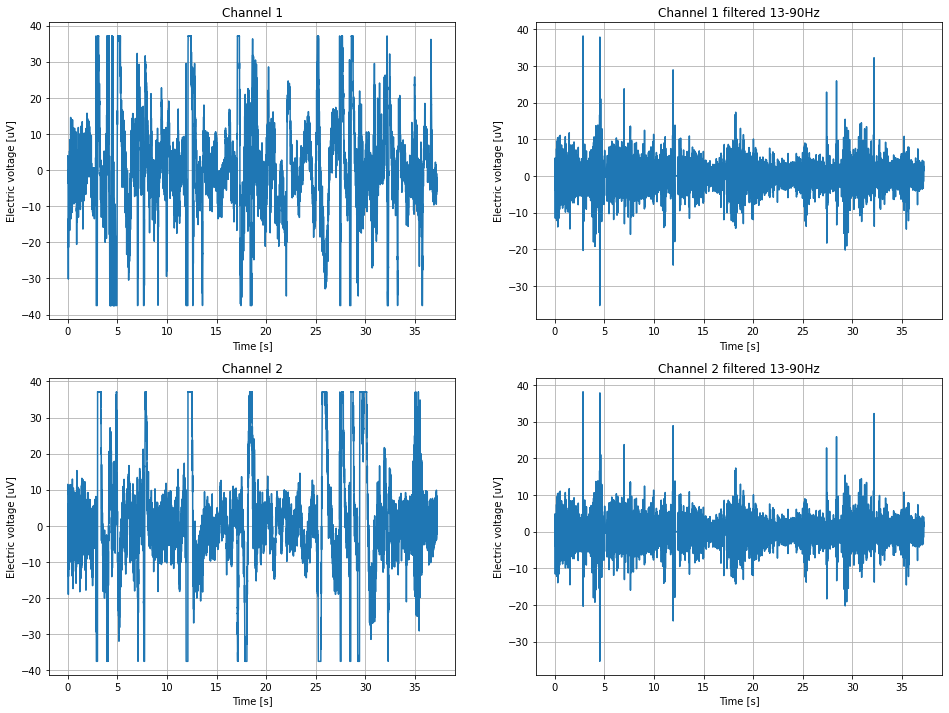

In [19]:
f, axs = plt.subplots(2, 2, figsize=(16,12))
axs[0,0].plot(time_ch1, signal_ch1)
axs[0,0].set_title('Channel 1')
axs[0,0].grid()
axs[0,0].set_ylabel('Electric voltage [uV]')
axs[0,0].set_xlabel('Time [s]')
axs[0,1].plot(time_ch1_, ch1_filtered_13_90)
axs[0,1].set_title('Channel 1 filtered 13-90Hz')
axs[0,1].grid()
axs[0,1].set_ylabel('Electric voltage [uV]')
axs[0,1].set_xlabel('Time [s]')
axs[1,0].plot(time_ch2, signal_ch2)
axs[1,0].set_title('Channel 2')
axs[1,0].grid()
axs[1,0].set_ylabel('Electric voltage [uV]')
axs[1,0].set_xlabel('Time [s]')
axs[1,1].plot(time_ch2_, ch2_filtered_13_90)
axs[1,1].set_title('Channel 2 filtered 13-90Hz')
axs[1,1].grid()
axs[1,1].set_ylabel('Electric voltage [uV]')
axs[1,1].set_xlabel('Time [s]')

Notice how the signal is very much modified, only the part of the brainwaves related to the gamma and beta band is being isolated. With this filtering, artefacts due to e.g. blinking or physical movements are also eliminated as the frequency of these artefacts results to be very low. 

Now we apply also the narrow filter to both channels:

In [20]:
ch1_filtered_8_12 = butter_bandpass_filter(ch1_shift_window, low_cuttoff_narrow, high_cuttoff_narrow, 1000, 1)
ch2_filtered_8_12 = butter_bandpass_filter(ch2_shift_window, low_cuttoff_narrow, high_cuttoff_narrow, 1000, 1)

time_ch1_ = bsnb.generate_time(ch1_filtered_8_12, sampling_rate)
time_ch2_ = bsnb.generate_time(ch2_filtered_8_12, sampling_rate)

Text(0.5, 0, 'Time [s]')

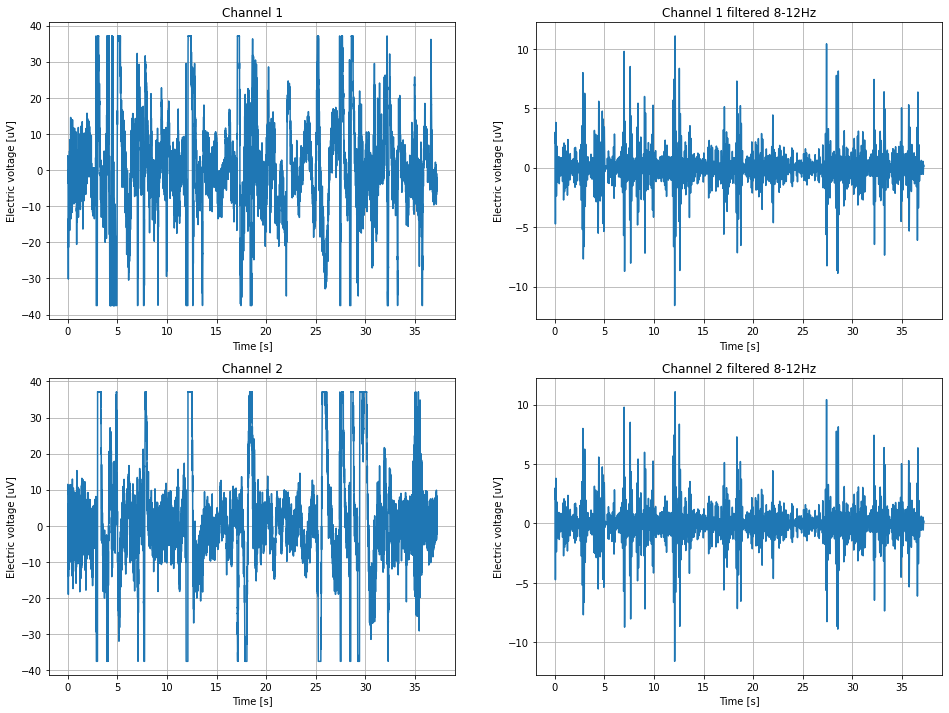

In [21]:
f, axs = plt.subplots(2, 2, figsize=(16,12))
axs[0,0].plot(time_ch1, signal_ch1)
axs[0,0].set_title('Channel 1')
axs[0,0].grid()
axs[0,0].set_ylabel('Electric voltage [uV]')
axs[0,0].set_xlabel('Time [s]')
axs[0,1].plot(time_ch1_, ch1_filtered_8_12)
axs[0,1].set_title('Channel 1 filtered 8-12Hz')
axs[0,1].grid()
axs[0,1].set_ylabel('Electric voltage [uV]')
axs[0,1].set_xlabel('Time [s]')
axs[1,0].plot(time_ch2, signal_ch2)
axs[1,0].set_title('Channel 2')
axs[1,0].grid()
axs[1,0].set_ylabel('Electric voltage [uV]')
axs[1,0].set_xlabel('Time [s]')
axs[1,1].plot(time_ch2_, ch2_filtered_8_12)
axs[1,1].set_title('Channel 2 filtered 8-12Hz')
axs[1,1].grid()
axs[1,1].set_ylabel('Electric voltage [uV]')
axs[1,1].set_xlabel('Time [s]')

To better visualise the differences before and after applying the different filters, we apply an FFT to the signals:

(0.0, 60.0)

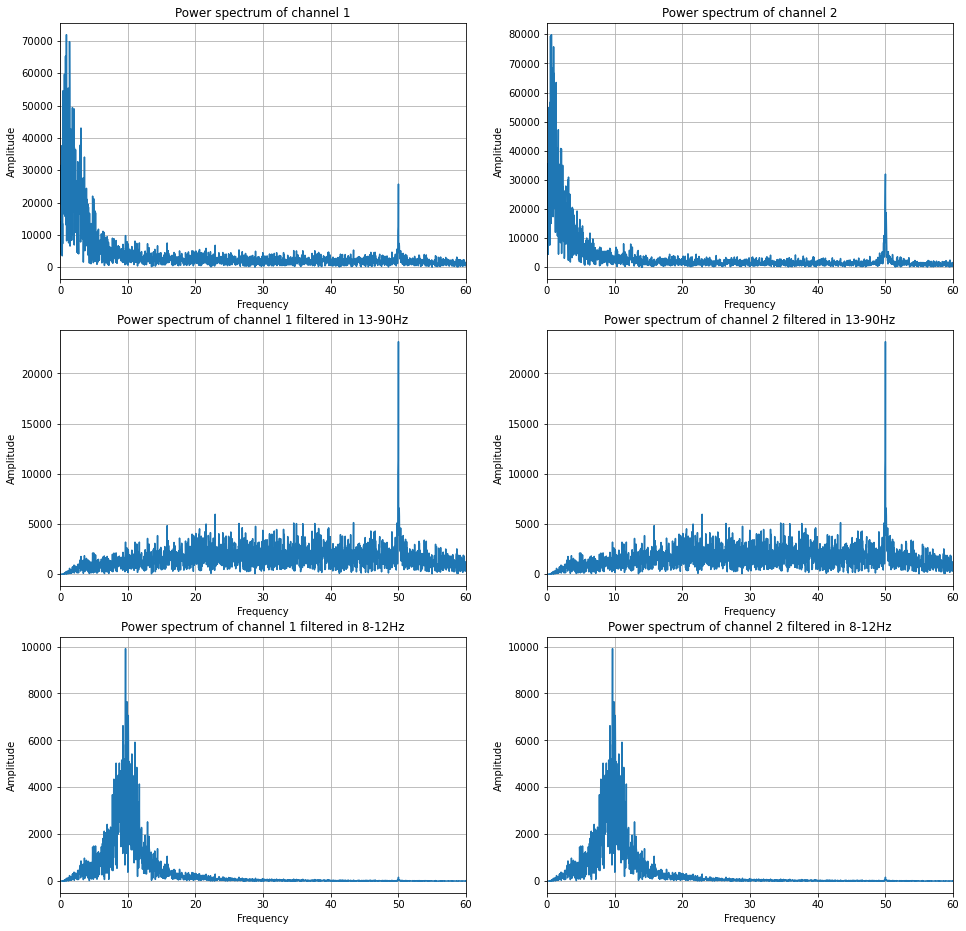

In [22]:
freq_axis_ch1, power_spect_ch1 = bsnb.plotfft(signal_ch1, sampling_rate)
freq_axis_ch2, power_spect_ch2 = bsnb.plotfft(signal_ch2, sampling_rate)
freq_axis_13_90_ch1, power_spect_3_30_ch1 = bsnb.plotfft(ch1_filtered_13_90, sampling_rate)
freq_axis_13_90_ch2, power_spect_3_30_ch2 = bsnb.plotfft(ch2_filtered_13_90, sampling_rate)
freq_axis_8_12_ch1, power_spect_8_12_ch1 = bsnb.plotfft(ch1_filtered_8_12, sampling_rate)
freq_axis_8_12_ch2, power_spect_8_12_ch2 = bsnb.plotfft(ch2_filtered_8_12, sampling_rate)

f, axs = plt.subplots(3, 2, figsize=(16,16))
axs[0,0].plot(freq_axis_ch1, power_spect_ch1)
axs[0,0].set_title('Power spectrum of channel 1')
axs[0,0].set_ylabel('Amplitude')
axs[0,0].set_xlabel('Frequency')
axs[0,0].grid()
axs[0,0].set_xlim([0, 60])
axs[0,1].plot(freq_axis_ch2, power_spect_ch2)
axs[0,1].set_title('Power spectrum of channel 2')
axs[0,1].set_ylabel('Amplitude')
axs[0,1].set_xlabel('Frequency')
axs[0,1].grid()
axs[0,1].set_xlim([0, 60])
axs[1,0].plot(freq_axis_13_90_ch1, power_spect_3_30_ch1)
axs[1,0].set_title('Power spectrum of channel 1 filtered in 13-90Hz')
axs[1,0].set_ylabel('Amplitude')
axs[1,0].set_xlabel('Frequency')
axs[1,0].grid()
axs[1,0].set_xlim([0, 60])
axs[1,1].plot(freq_axis_13_90_ch2, power_spect_3_30_ch2)
axs[1,1].set_title('Power spectrum of channel 2 filtered in 13-90Hz')
axs[1,1].set_ylabel('Amplitude')
axs[1,1].set_xlabel('Frequency')
axs[1,1].grid()
axs[1,1].set_xlim([0, 60])
axs[2,0].plot(freq_axis_8_12_ch1, power_spect_8_12_ch1)
axs[2,0].set_title('Power spectrum of channel 1 filtered in 8-12Hz')
axs[2,0].set_ylabel('Amplitude')
axs[2,0].set_xlabel('Frequency')
axs[2,0].grid()
axs[2,0].set_xlim([0, 60])
axs[2,1].plot(freq_axis_8_12_ch2, power_spect_8_12_ch2)
axs[2,1].set_title('Power spectrum of channel 2 filtered in 8-12Hz')
axs[2,1].set_ylabel('Amplitude')
axs[2,1].set_xlabel('Frequency')
axs[2,1].grid()
axs[2,1].set_xlim([0, 60])

Welchs method can be applied to the FFT of the signal for specific time windows to estimate the power spectral density.

In [23]:
#Power Spectrum
#Time Windows for Welchs method 
win = 4 * sampling_rate
#FFT with time windows using scipy.signal.welch for the 3-30Hz filtered signal
freq_axis_welch_ch1_13_90, power_spect_welch_ch1_13_90 = welch(ch1_filtered_13_90, sampling_rate, nperseg=win)
freq_axis_welch_ch2_13_90, power_spect_welch_ch2_13_90 = welch(ch2_filtered_13_90, sampling_rate, nperseg=win)
#FFT with time windows using scipy.signal.welch for the 8-12Hz filtered signal
freq_axis_welch_ch1_8_12, power_spect_welch_ch1_8_12 = welch(ch1_filtered_8_12, sampling_rate, nperseg=win)
freq_axis_welch_ch2_8_12, power_spect_welch_ch2_8_12 = welch(ch2_filtered_8_12, sampling_rate, nperseg=win)

Text(0.5, 0, 'Frequency [Hz]')

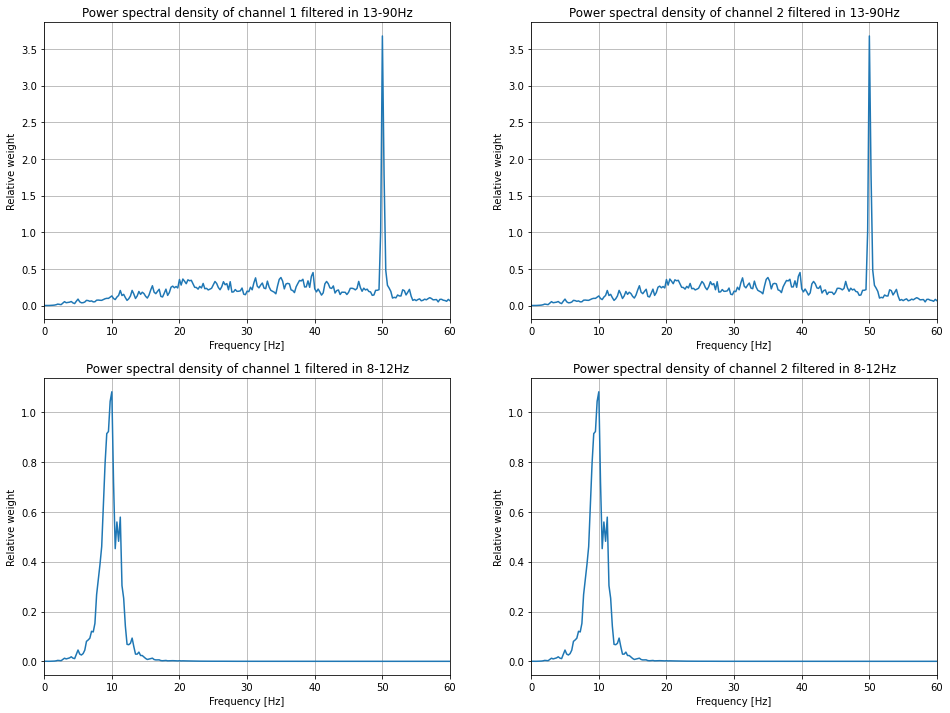

In [24]:
f, axs = plt.subplots(2, 2, figsize=(16,12))
axs[0,0].plot(freq_axis_welch_ch1_13_90, power_spect_welch_ch1_13_90)
axs[0,0].set_title('Power spectral density of channel 1 filtered in 13-90Hz')
axs[0,0].grid()
axs[0,0].set_xlim([0, 60])
axs[0,0].set_ylabel('Relative weight')
axs[0,0].set_xlabel('Frequency [Hz]')
axs[0,1].plot(freq_axis_welch_ch2_13_90, power_spect_welch_ch2_13_90)
axs[0,1].set_title('Power spectral density of channel 2 filtered in 13-90Hz')
axs[0,1].grid()
axs[0,1].set_xlim([0, 60])
axs[0,1].set_ylabel('Relative weight')
axs[0,1].set_xlabel('Frequency [Hz]')
axs[1,0].plot(freq_axis_welch_ch1_8_12, power_spect_welch_ch1_8_12)
axs[1,0].set_title('Power spectral density of channel 1 filtered in 8-12Hz')
axs[1,0].grid()
axs[1,0].set_xlim([0, 60])
axs[1,0].set_ylabel('Relative weight')
axs[1,0].set_xlabel('Frequency [Hz]')
axs[1,1].plot(freq_axis_welch_ch2_8_12, power_spect_welch_ch2_8_12)
axs[1,1].set_title('Power spectral density of channel 2 filtered in 8-12Hz')
axs[1,1].grid()
axs[1,1].set_xlim([0, 60])
axs[1,1].set_ylabel('Relative weight')
axs[1,1].set_xlabel('Frequency [Hz]')

It is evident from the spectrum that there is a very marked harmonic at 50Hz, this is not due to brain activity but to mains disturbances that override the seganle measured by the sensors.  We also note how this harmonic is very pronounced, despite the fact that the device is not directly connected to the grid. 

To eliminate this disturbance, we use a second-order digital IIR notch filter. This type of filter only removes one band from the rye and leaves the rest of the signal unchanged.  

In [25]:
fs = sampling_rate
f0 = 50.0  # Frequency to be removed from signal (Hz)
Q = 30.0  # Quality factor

# Design notch filter
b, a = signal.iirnotch(f0, Q, fs)

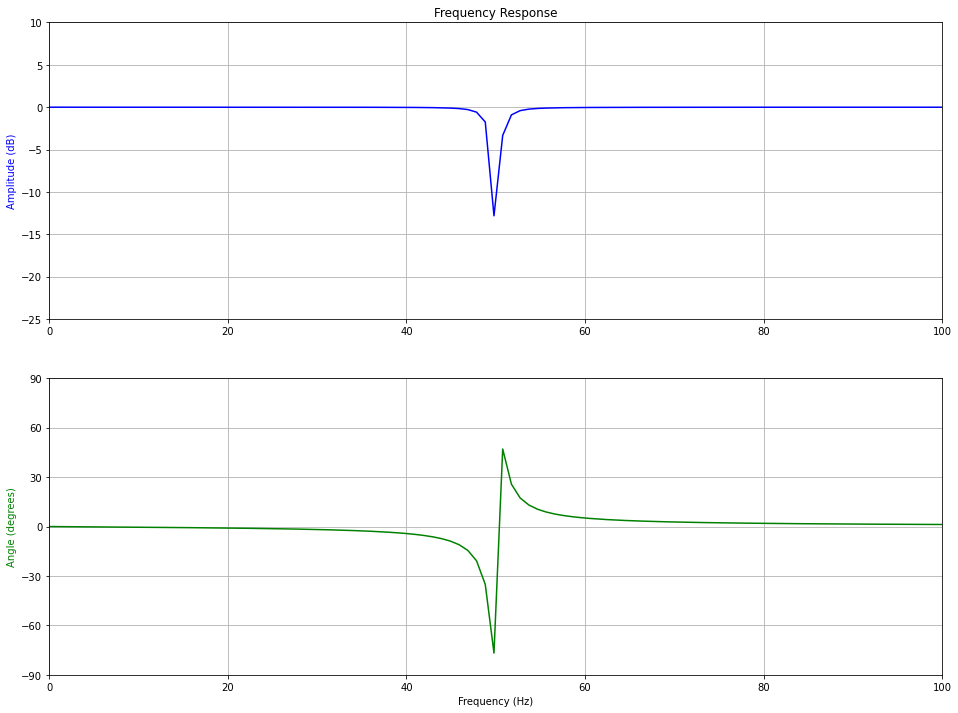

In [26]:
# Frequency response
freq, h = signal.freqz(b, a, fs=fs)

# Plot
fig, ax = plt.subplots(2, 1, figsize=(16, 12))
ax[0].plot(freq, 20*np.log10(abs(h)), color='blue')
ax[0].set_title("Frequency Response")
ax[0].set_ylabel("Amplitude (dB)", color='blue')
ax[0].set_xlim([0, 100])
ax[0].set_ylim([-25, 10])
ax[0].grid(True)
ax[1].plot(freq, np.unwrap(np.angle(h))*180/np.pi, color='green')
ax[1].set_ylabel("Angle (degrees)", color='green')
ax[1].set_xlabel("Frequency (Hz)")
ax[1].set_xlim([0, 100])
ax[1].set_yticks([-90, -60, -30, 0, 30, 60, 90])
ax[1].set_ylim([-90, 90])
ax[1].grid(True)
plt.show()

As can be seen from the module graph, we manage to eliminate the relative band at 50Hz. Quality factor. Dimensionless parameter that characterizes notch filter -3 dB bandwidth bw relative to its center frequency, Q = w0/bw.

Now apply the notch filter to the shifted signals from the two channels

In [27]:
notch_ch1 = signal.filtfilt(b, a, ch1_shift_window)
notch_ch2 = signal.filtfilt(b, a, ch2_shift_window)

Text(0.5, 0, 'Time [s]')

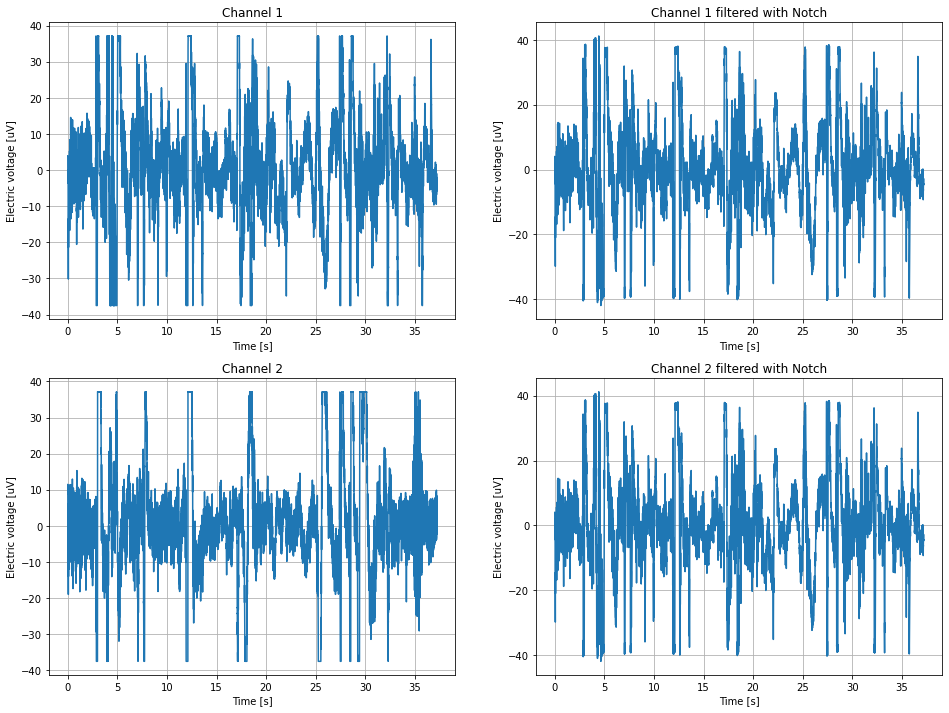

In [28]:
f, axs = plt.subplots(2, 2, figsize=(16,12))
axs[0,0].plot(time_ch1, signal_ch1)
axs[0,0].set_title('Channel 1')
axs[0,0].grid()
axs[0,0].set_ylabel('Electric voltage [uV]')
axs[0,0].set_xlabel('Time [s]')
axs[0,1].plot(time_ch1_, notch_ch1)
axs[0,1].set_title('Channel 1 filtered with Notch')
axs[0,1].grid()
axs[0,1].set_ylabel('Electric voltage [uV]')
axs[0,1].set_xlabel('Time [s]')
axs[1,0].plot(time_ch2, signal_ch2)
axs[1,0].set_title('Channel 2')
axs[1,0].grid()
axs[1,0].set_ylabel('Electric voltage [uV]')
axs[1,0].set_xlabel('Time [s]')
axs[1,1].plot(time_ch2_, notch_ch2)
axs[1,1].set_title('Channel 2 filtered with Notch')
axs[1,1].grid()
axs[1,1].set_ylabel('Electric voltage [uV]')
axs[1,1].set_xlabel('Time [s]')

At this point, we again perform the analysis initially proposed to remove the delta and theta (sleep stage) brainwaves. And to separate the alpha brainwaves from the beta and gamma brainwaves. 

Filter with a bandpass between the frequencies of 13 and 90Hz to consider only the beta and gamma brainwaves component:

In [29]:
ch1_filtered_13_90_Notch = butter_bandpass_filter(notch_ch1, low_cuttoff_wide, high_cuttoff_wide, 1000, 1)
ch2_filtered_13_90_Notch = butter_bandpass_filter(notch_ch2, low_cuttoff_wide, high_cuttoff_wide, 1000, 1)

time_ch1_ = bsnb.generate_time(ch1_filtered_13_90_Notch, sampling_rate)
time_ch2_ = bsnb.generate_time(ch2_filtered_13_90_Notch, sampling_rate)

Text(0.5, 0, 'Time [s]')

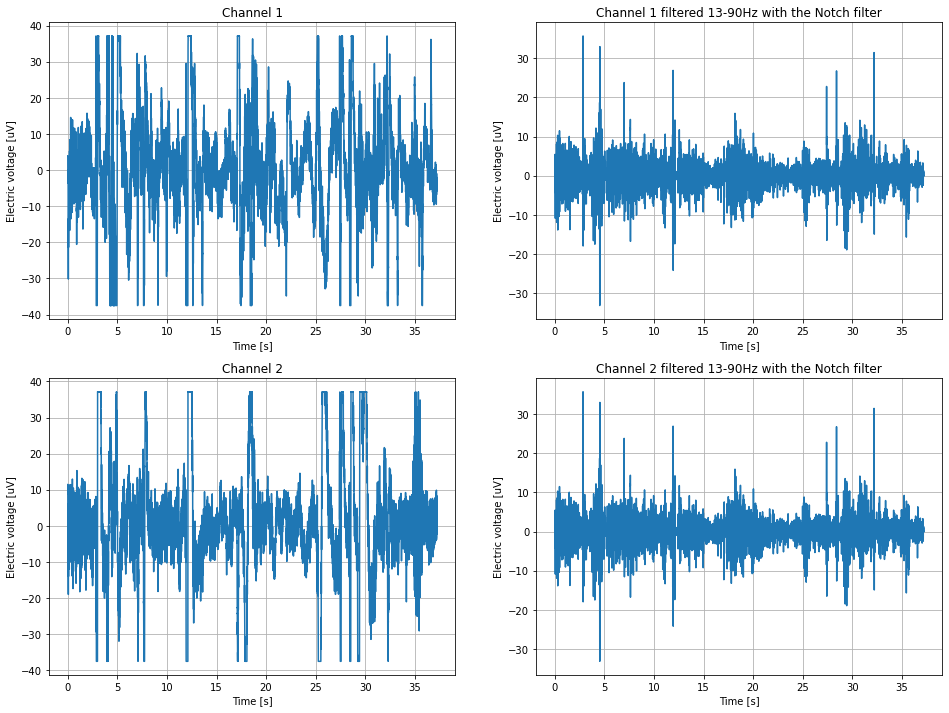

In [30]:
f, axs = plt.subplots(2, 2, figsize=(16,12))
axs[0,0].plot(time_ch1, signal_ch1)
axs[0,0].set_title('Channel 1')
axs[0,0].grid()
axs[0,0].set_ylabel('Electric voltage [uV]')
axs[0,0].set_xlabel('Time [s]')
axs[0,1].plot(time_ch1_, ch1_filtered_13_90_Notch)
axs[0,1].set_title('Channel 1 filtered 13-90Hz with the Notch filter')
axs[0,1].grid()
axs[0,1].set_ylabel('Electric voltage [uV]')
axs[0,1].set_xlabel('Time [s]')
axs[1,0].plot(time_ch2, signal_ch2)
axs[1,0].set_title('Channel 2')
axs[1,0].grid()
axs[1,0].set_ylabel('Electric voltage [uV]')
axs[1,0].set_xlabel('Time [s]')
axs[1,1].plot(time_ch2_, ch2_filtered_13_90_Notch)
axs[1,1].set_title('Channel 2 filtered 13-90Hz with the Notch filter')
axs[1,1].grid()
axs[1,1].set_ylabel('Electric voltage [uV]')
axs[1,1].set_xlabel('Time [s]')

To consider only the alpha brainwaves instead, filter with a bandpass between 8 and 13 Hz. 

In [31]:
ch1_filtered_8_12_Notch = butter_bandpass_filter(notch_ch1, low_cuttoff_narrow, high_cuttoff_narrow, 1000, 1)
ch2_filtered_8_12_Notch = butter_bandpass_filter(notch_ch2, low_cuttoff_narrow, high_cuttoff_narrow, 1000, 1)

time_ch1_ = bsnb.generate_time(ch1_filtered_8_12_Notch, sampling_rate)
time_ch2_ = bsnb.generate_time(ch2_filtered_8_12_Notch, sampling_rate)

Text(0.5, 0, 'Time [s]')

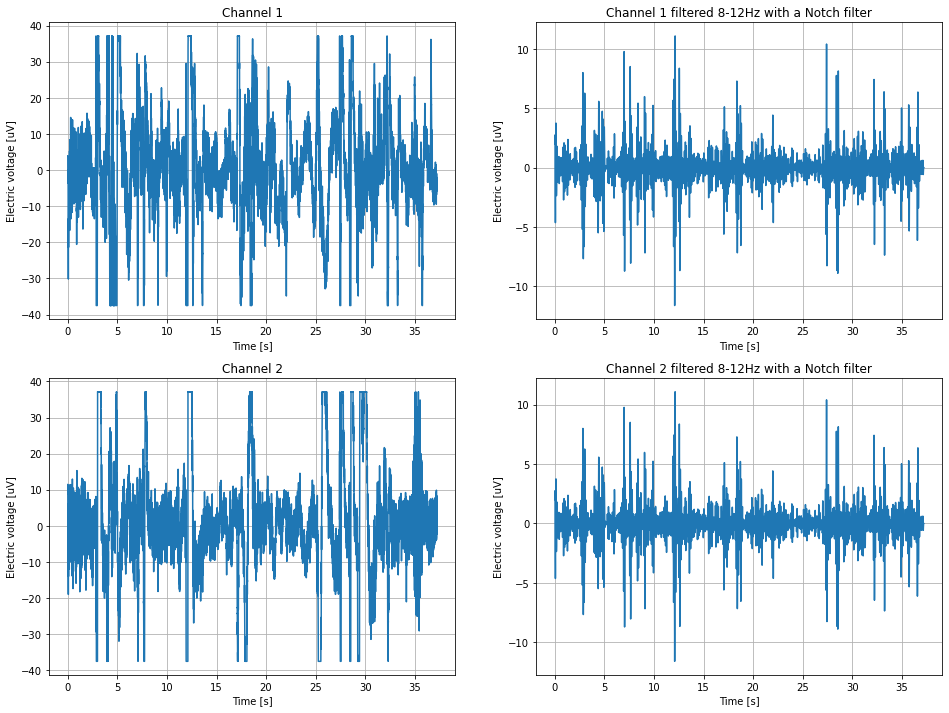

In [32]:
f, axs = plt.subplots(2, 2, figsize=(16,12))
axs[0,0].plot(time_ch1, signal_ch1)
axs[0,0].set_title('Channel 1')
axs[0,0].grid()
axs[0,0].set_ylabel('Electric voltage [uV]')
axs[0,0].set_xlabel('Time [s]')
axs[0,1].plot(time_ch1_, ch1_filtered_8_12_Notch)
axs[0,1].set_title('Channel 1 filtered 8-12Hz with a Notch filter')
axs[0,1].grid()
axs[0,1].set_ylabel('Electric voltage [uV]')
axs[0,1].set_xlabel('Time [s]')
axs[1,0].plot(time_ch2, signal_ch2)
axs[1,0].set_title('Channel 2')
axs[1,0].grid()
axs[1,0].set_ylabel('Electric voltage [uV]')
axs[1,0].set_xlabel('Time [s]')
axs[1,1].plot(time_ch2_, ch2_filtered_8_12_Notch)
axs[1,1].set_title('Channel 2 filtered 8-12Hz with a Notch filter')
axs[1,1].grid()
axs[1,1].set_ylabel('Electric voltage [uV]')
axs[1,1].set_xlabel('Time [s]')

We then plot the spectrum of the signals with the notch filter applied:

(0.0, 60.0)

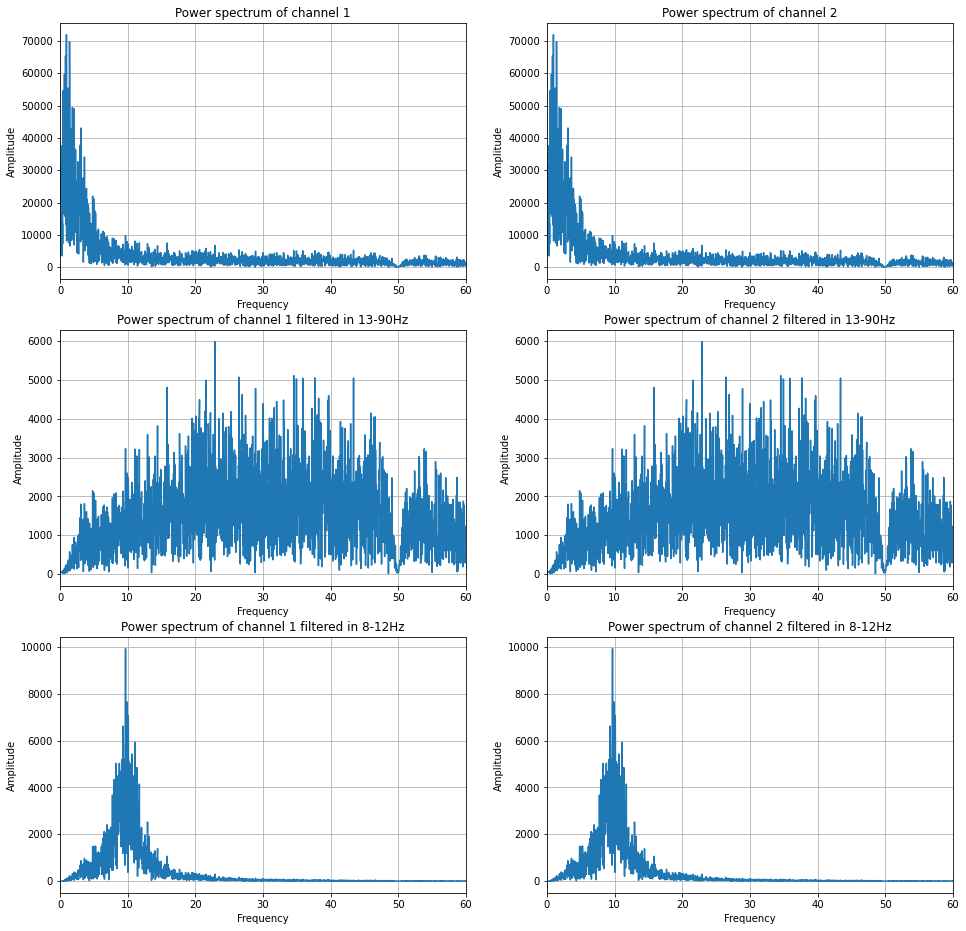

In [33]:
freq_axis_ch1_notch, power_spect_ch1_notch = bsnb.plotfft(notch_ch1, sampling_rate)
freq_axis_ch2_notch, power_spect_ch2_notch = bsnb.plotfft(notch_ch2, sampling_rate)
freq_axis_13_90_ch1_notch, power_spect_13_90_ch1_notch = bsnb.plotfft(ch1_filtered_13_90_Notch, sampling_rate)
freq_axis_13_90_ch2_notch, power_spect_13_90_ch2_notch = bsnb.plotfft(ch2_filtered_13_90_Notch, sampling_rate)
freq_axis_8_12_ch1_notch, power_spect_8_12_ch1_notch = bsnb.plotfft(ch1_filtered_8_12_Notch, sampling_rate)
freq_axis_8_12_ch2_notch, power_spect_8_12_ch2_notch = bsnb.plotfft(ch2_filtered_8_12_Notch, sampling_rate)

f, axs = plt.subplots(3, 2, figsize=(16,16))
axs[0,0].plot(freq_axis_ch1_notch, power_spect_ch1_notch)
axs[0,0].set_title('Power spectrum of channel 1')
axs[0,0].grid()
axs[0,0].set_ylabel('Amplitude')
axs[0,0].set_xlabel('Frequency')
axs[0,0].set_xlim([0, 60])
axs[0,1].plot(freq_axis_ch2_notch, power_spect_ch2_notch)
axs[0,1].set_title('Power spectrum of channel 2')
axs[0,1].grid()
axs[0,1].set_ylabel('Amplitude')
axs[0,1].set_xlabel('Frequency')
axs[0,1].set_xlim([0, 60])
axs[1,0].plot(freq_axis_13_90_ch1_notch, power_spect_13_90_ch1_notch)
axs[1,0].set_title('Power spectrum of channel 1 filtered in 13-90Hz')
axs[1,0].grid()
axs[1,0].set_ylabel('Amplitude')
axs[1,0].set_xlabel('Frequency')
axs[1,0].set_xlim([0, 60])
axs[1,1].plot(freq_axis_13_90_ch2_notch, power_spect_13_90_ch2_notch)
axs[1,1].set_title('Power spectrum of channel 2 filtered in 13-90Hz')
axs[1,1].grid()
axs[1,1].set_ylabel('Amplitude')
axs[1,1].set_xlabel('Frequency')
axs[1,1].set_xlim([0, 60])
axs[2,0].plot(freq_axis_8_12_ch1_notch, power_spect_8_12_ch1_notch)
axs[2,0].set_title('Power spectrum of channel 1 filtered in 8-12Hz')
axs[2,0].grid()
axs[2,0].set_ylabel('Amplitude')
axs[2,0].set_xlabel('Frequency')
axs[2,0].set_xlim([0, 60])
axs[2,1].plot(freq_axis_8_12_ch2_notch, power_spect_8_12_ch2_notch)
axs[2,1].set_title('Power spectrum of channel 2 filtered in 8-12Hz')
axs[2,1].grid()
axs[2,1].set_ylabel('Amplitude')
axs[2,1].set_xlabel('Frequency')
axs[2,1].set_xlim([0, 60])

We can see that the component due to mains disturbance at 50Hz is completely eliminated by the filter and that only the components of interest remain. 